In [10]:
# read csv with pandas
import pandas as pd

data_path = '../data_input/train.csv'
df = pd.read_csv(data_path, usecols=['id', 'text', 'label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157789 entries, 0 to 157788
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      157789 non-null  object
 1   text    157789 non-null  object
 2   label   157789 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [4]:
import lightning as L
import torch.nn as nn
import torch
import torch.nn.functional as F

In [13]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class Config:
    vocab_size: int
    n_embd: int
    n_hidden: int
    batch_size: int
    context_length: int
    n_workers: int
    # /path/to/save/checkpoints
    ckpt_path = None
    dropout = 0.1
    checkpoint_dir: Path = Path("../output/checkpoints/").absolute()


def get_default_config() -> Config:
    cfg =  Config(
        n_workers=1,
        vocab_size=5001,
        n_embd=16,
        n_hidden=64,
        batch_size=32,
        context_length=32,
    )

    # Get the latest checkpoint file path
    latest_ckpt_file = sorted(cfg.checkpoint_dir.glob('*.ckpt'), key=lambda x: x.stat().st_mtime, reverse=True)
    cfg.ckpt_path = None if latest_ckpt_file == [] else latest_ckpt_file[0]
    return cfg

cfg = get_default_config()

In [36]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(cfg.n_embd, head_size, bias=False)
        self.query = nn.Linear(cfg.n_embd, head_size, bias=False)
        self.value = nn.Linear(cfg.n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(cfg.context_length, cfg.context_length)))

        self.dropout = nn.Dropout(cfg.dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(cfg.n_embd, cfg.n_embd)
        self.dropout = nn.Dropout(cfg.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(cfg.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransfEncModel(L.LightningModule):
    def __init__(self, cfg: Config, n_classes=5):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
        self.position_embedding_table = nn.Embedding(cfg.context_length, cfg.n_embd)
        self.blocks = nn.Sequential(*[Block(cfg.n_embd, n_head=1) for _ in range(1)])
        self.ln_f = nn.LayerNorm(cfg.n_embd) # final layer norm
        self.lm_head = nn.Linear(cfg.context_length * cfg.n_embd, n_classes)

    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        B, T, C = x.shape
        x = x.view(B, T*C)  # (B,T,C) -> (B, T*C)
        logits = self.lm_head(x) # (B,n_classes)

        return logits

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs)
        loss = torch.nn.functional.cross_entropy(output, target.view(-1))
        # lossi.append(loss.log10().item())
        # with torch.no_grad():
        # lr = optimizer.param_groups[0]['lr']
        # ud.append([((lr*p.grad).std() / p.output.std()).log10().item() for p in model.parameters()])
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log(
            "train_loss", loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True
        )
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.01)

    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs)
        loss = torch.nn.functional.cross_entropy(output, target.view(-1))
        self.log("val_loss", loss, on_step=True, on_epoch=True,prog_bar=True, sync_dist=True)
        return loss

In [26]:
# split X and Y into train and val, stratify by Y
import sys
sys.path.append(".")

from script.data import get_train_test_split

Xtr, Xval, Ytr, Yval = get_train_test_split(
    df["text"], df["label"], context_length=cfg.context_length, test_size=0.2
)

Vocab size: 5001


In [27]:
Xtr.shape, Xval.shape

(torch.Size([126231, 32]), torch.Size([31558, 32]))

In [37]:
model = TransfEncModel(cfg)
sum([p.nelement() for p in model.parameters()])

86357

In [38]:
layers = list(model.modules())[1:]

In [39]:
# Define the forward hook function
def forward_hook(module, input, output):
    module.out = output  # Store output in the module itself
    # module.out.retain_grad()  # Tell PyTorch to keep the gradient

In [40]:
# loop over model layers except the last one
for layer in layers[:-1]:
  layer.register_forward_hook(forward_hook)
  print(layer)

Embedding(5001, 16)
Embedding(32, 16)
Sequential(
  (0): Block(
    (sa): MultiHeadAttention(
      (heads): ModuleList(
        (0): Head(
          (key): Linear(in_features=16, out_features=16, bias=False)
          (query): Linear(in_features=16, out_features=16, bias=False)
          (value): Linear(in_features=16, out_features=16, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (proj): Linear(in_features=16, out_features=16, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (ffwd): FeedFoward(
      (net): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=16, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (ln1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
)
Block(
  (sa): MultiHeadAttention(
    (heads): ModuleList(
      (0): Hea

In [32]:
# train with pytorch lightning
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(Xtr, Ytr)
val_dataset = TensorDataset(Xval, Yval)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

In [42]:
trainer = L.Trainer(max_epochs=2, accelerator='cpu')

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs

  | Name                     | Type       | Params
--------------------------------------------------------
0 | token_embedding_table    | Embedding  | 80.0 K
1 | position_embedding_table | Embedding  | 512   
2 | blocks                   | Sequential | 3.2 K 
3 | ln_f                     | LayerNorm  | 32    
4 | lm_head                  | Linear     | 2.6 K 
--------------------------------------------------------
86.4 K    Trainable params
0         Non-trainable params
86.4 K    Total params
0.345     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\paul-\anaconda3\envs\ml_angew_programm\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\paul-\anaconda3\envs\ml_angew_programm\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Text(0.5, 1.0, 'activation distribution')

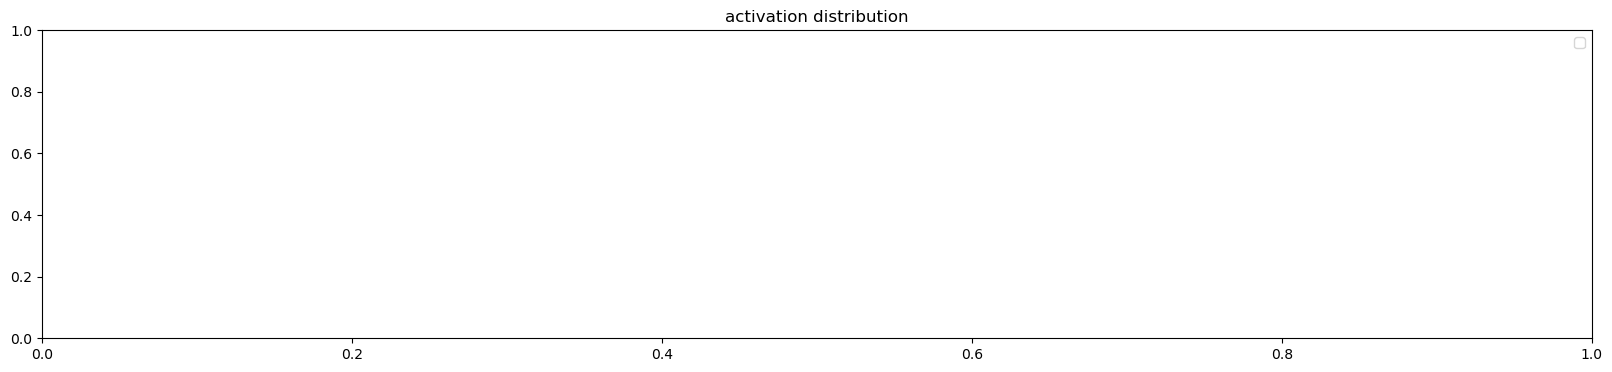

In [43]:
import matplotlib.pyplot as plt

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

Text(0.5, 1.0, 'gradient distribution')

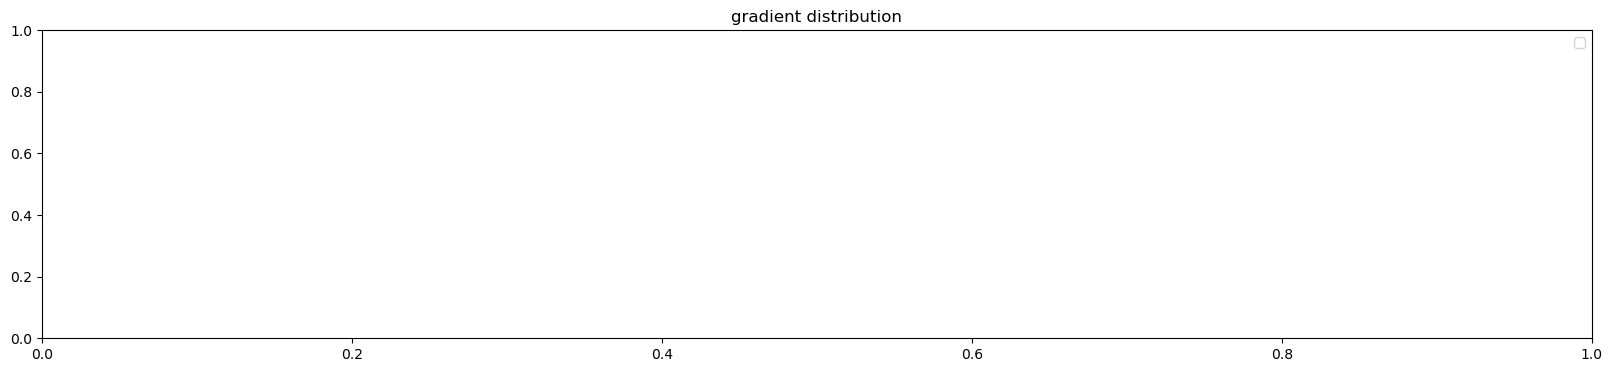

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

In [46]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

NameError: name 'ud' is not defined

<Figure size 2000x400 with 0 Axes>

In [47]:
# with torch.no_grad():
    # train validation loss
# outputs1 = model(Xtr)
# loss = F.cross_entropy(outputs1, Ytr)
# print(f'Training loss: {loss.item():.4f}')

outputs = model(Xval)
loss = torch.functional.F.cross_entropy(outputs, Yval)
print(f'Validation loss: {loss.item():.4f}')

Validation loss: 1.0960


tensor(1.1228, grad_fn=<NllLossBackward0>)  
tensor(1.0828, grad_fn=<NllLossBackward0>)  
tensor(1.0767, grad_fn=<NllLossBackward0>) on mlpc  
Validation loss: 1.0657 on wavenet

In [48]:
from sklearn.metrics import classification_report

Y_pred = outputs.argmax(dim=1).detach().numpy()
Y_true = Yval.numpy()

print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.64      6353
           1       0.43      0.36      0.39      6462
           2       0.40      0.35      0.38      6337
           3       0.46      0.50      0.48      6244
           4       0.63      0.75      0.68      6162

    accuracy                           0.52     31558
   macro avg       0.51      0.52      0.51     31558
weighted avg       0.51      0.52      0.51     31558

